In [27]:
from matplotlib import pyplot as plt
import errno

plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'figure.max_open_warning': 0})

import numpy as np
import os
import pandas as pd

import threading

In [163]:
def plot_cwnd_vs_time_individual(noOfSources=2, rtt1="10ms", rtt2="10ms", flavour="TcpBbr", part = 0):
    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(6)
    file_location = f"/mnt/Store/Project-summer/runtime/{flavour}/{rtt1+rtt2}/{noOfSources}/cwndDropTail.txt"
  
    # Read data from the file
    data = pd.read_csv(file_location, sep='\t')

    # Convert the DataFrame to numeric values
    data = data.apply(pd.to_numeric, errors='coerce')

    # Extract Source IDs and their corresponding values
    source_ids = data['SourceID']
    source_data = data.drop(columns=['SourceID'])

    # Calculate the index to plot 75% of the data
    if part > 0:
        data_length = len(source_data.iloc[0])
        start_index = int(part * data_length)
        end_index = data_length
    else:
        start_index = 0
        end_index = len(source_data.iloc[0])
        
    
    # Plot a graph for each Source ID within the specified range
    for i, source_id in enumerate(source_ids):
        plt.plot(range(start_index, end_index), source_data.iloc[i, start_index:end_index])

    plt.xlabel("time")
    plt.ylabel("cwnd")
    plt.title(f"Congestion windows size vs time     Sources:{noOfSources}    RTT:{rtt1+rtt2}    Flavour:{flavour}")


# Example for plot_cwnd_vs_time:
def plot_cwnd_vs_time(noOfSources=2, rtt1="10ms", rtt2="10ms", flavour="TcpBbr",  part = 0):
    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(6)

    file_location = f"/mnt/Store/Project-summer/runtime/{flavour}/{rtt1+rtt2}/{noOfSources}/cwndDropTail.txt"

    # Read data from the file
    data = pd.read_csv(file_location, sep='\t')

    # Convert the DataFrame to numeric values
    data = data.apply(pd.to_numeric, errors='coerce')

    # Drop the SourceID column to calculate the average across all Source IDs for each timestamp
    data_no_id = data.drop(columns=['SourceID'])

    # Calculate the average at each timestamp (second)
    average_values = data_no_id.mean(axis=0)

    # Adjust data to plot 75% if ss = "yes"
    
    if part > 0:
        breakpoint()
        data_length = len(average_values)
        start_index = int(part * data_length)
        end_index = data_length
        plt.plot(range(start_index, end_index), average_values[start_index:end_index])
    else:
        start_index = 0
        end_index = len(average_values)
        plt.plot(range(start_index, end_index), average_values)

    plt.xlabel("time")
    plt.ylabel("avg cwnd")
    plt.title(f"Average Congestion windows size vs time     Sources:{noOfSources}    RTT:{rtt1+rtt2}    Flavour:{flavour}")
 
# ... (Previous code remains unchanged)

def plot_dropped_vs_time(noOfSources=2, rtt1="10ms", rtt2="10ms", flavour="TcpBbr",  part = 0, total_time = 200):
    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(6)
    
    droppedpvstime = {}
    
    with open(f"/mnt/Store/Project-summer/runtime/{flavour}/{rtt1+rtt2}/{noOfSources}/droppedPacketTrace.txt", "r") as file:
        lines = file.readlines()
        prev = 0
        
        for line in lines:
            split_line = line.split()
            droppedpvstime[float(split_line[0])] = int(split_line[1]) - prev
            prev = int(split_line[1])

    # Convert the dictionary to lists for slicing
    time_values = list(droppedpvstime.keys())
    dropped_values = list(droppedpvstime.values())

    if part > 0:
        time_values_part = []
        dropped_values_part = []
        for time, dropped in droppedpvstime.items():
            if ( time > part*total_time ):
                time_values_part.append(time)
                dropped_values_part.append(dropped)
        
        plt.plot(time_values_part, dropped_values_part)
    else:
        plt.plot(time_values, dropped_values)

    plt.xlabel("time")
    plt.ylabel("Packet Dropped")
    plt.title(f"Packet Dropped vs time     Sources:{noOfSources}    RTT:{rtt1+rtt2}    Flavour:{flavour}")


def plot_link_utilization_vs_time(noOfSources=2, rtt1="10ms", rtt2="10ms", flavour="TcpBbr",  part = 0, maxQSize="2084p", bottleneck_bandwidth=100, packetSize=1458):
    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(6)

    linkutilvstime = {}

    with open(f"/mnt/Store/Project-summer/runtime/{flavour}/{rtt1+rtt2}/{noOfSources}/bottleneckTx.txt", "r") as file:
        lines = file.readlines()
        prev_packetsTx = 0
    
        for line in lines:
            split_line = line.split()
            linkutilvstime[float(split_line[0])] = 100 * ((float(split_line[1]) - float(prev_packetsTx)) * packetSize) / ((bottleneck_bandwidth / 8) * 1024 * 1024)
            prev_packetsTx = split_line[1]

    time_values = list(linkutilvstime.keys())
    utilization_values = list(linkutilvstime.values())

    if part > 0:
        data_length = len(time_values)
        start_index = int(part * data_length)
        end_index = data_length
        plt.plot(time_values[start_index:end_index], utilization_values[start_index:end_index])
    else:
        plt.plot(time_values, utilization_values)

    plt.xlabel("time")
    plt.ylabel("Link utilization %")
    plt.title(f"Link utilization vs time     Sources:{noOfSources}    RTT:{rtt1+rtt2}    Flavour:{flavour}")


def plot_qsize_vs_time(noOfSources=2, rtt1="10ms", rtt2="10ms", flavour="TcpBbr",maxQSize="2084p", queueName="C", part = 0, total_time = 200):
    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(6)

    qutilvstime = {}

    with open(f"/mnt/Store/Project-summer/runtime/{flavour}/{rtt1+rtt2}/{noOfSources}/qsizeTrace_{queueName}.txt", "r") as file:
        lines = file.readlines()

        for line in lines:
            split_line = line.split()
            qutilvstime[float(split_line[0])] = float(split_line[1])

    time_values = list(qutilvstime.keys())
    qsize_values = list(qutilvstime.values())

    if part > 0:
        time_values_part = []
        qsize_values_part = []
        for time, qsize in qutilvstime.items():
            if ( time > part*total_time ):
                time_values_part.append(time)
                qsize_values_part.append(qsize)
        
        plt.plot(time_values_part, qsize_values_part)
                
    else:
        plt.plot(time_values, qsize_values)

    plt.xlabel("time")
    plt.ylabel("Q utilization (abs)")
    plt.title(f"Q utilization vs time for bottleneck {queueName}    Sources:{noOfSources}    RTT:{rtt1+rtt2}    Flavour:{flavour}")


def clean(flavor = "default" , 
          time = 200 , 
          queueL = 5, 
          noOfSource = 4, 
          total_input_bandwidth = 2, bottleneck_bandwidth = 1, RTT = 10, recvWindow = 50):
    os.system("rm -rf {}_{}_{}".format(flavor, noOfSource, RTT));
    
    

In [164]:
def main(flavour = "TcpBbr" , time = 200 ,total_access_bandwidth = 120, bottleneck_bandwidth_A = 200, bottleneck_bandwidth_B = 100, bottleneck_bandwidth_C = 100, 
         bottleneck_delay = 1 , RTT1 = "10ms", RTT2 = "10ms", packetSize = 1458, queueL = "5p", noOfSource = 2, 
         rcvBuff = 1458*10000, sndBuff = 1458*10000, enableBottleneckTrace = 0, SRBuffers = "off", run_simul = "yes", part = 0):
     
     if queueL[-3:] == "BDP":
          queueL = ((float(bottleneck_bandwidth_B[0:-4]) * (10**6) * float(2*bottleneck_delay[0:-2] + RTT1[0:-2]) * 10**(-3))/8)/packetSize
          queueL = str(queueL)+'p'
     
     
     # access_link_delay_val = RTT[0:-2]
     access_link_bandwidth_val = total_access_bandwidth[0:-4]
     
     #access_link_delay = str(float(access_link_delay_val)/4)+"ms"
     access_link_bandwidth = str(float(access_link_bandwidth_val)/noOfSource)+"Mbps"
     
     # lock = threading.Lock();
     
     
     # lock.acquire();   
     # Creating new directory structure to isolate 2 different processes and their output
     try: 
          if os.path.exists(f"/mnt/Store/Project-summer/runtime/{flavour}") == False:
               os.mkdir( f"/mnt/Store/Project-summer/runtime/{flavour}")
               
          if os.path.exists(f"/mnt/Store/Project-summer/runtime/{flavour}/{RTT1+RTT2}") == False:
               os.mkdir( f"/mnt/Store/Project-summer/runtime/{flavour}/{RTT1+RTT2}")
               
          if os.path.exists(f"/mnt/Store/Project-summer/runtime/{flavour}/{RTT1+RTT2}/{noOfSource}") == False:
               os.mkdir( f"/mnt/Store/Project-summer/runtime/{flavour}/{RTT1+RTT2}/{noOfSource}")
     except OSError as exc:
          if exc.errno != errno.EEXIST:
               raise
          pass
     
     # lock.release();
    
     # if os.path.exists("/mnt/Store/Project-summer/runtime"):
     #     os.system("rm -rf /mnt/Store/Project-summer/runtime/*")


     cmd = f'''./ns3 run \"scratch/tcp_ftp_n_bg --nSources={noOfSource} 
     --flavour={flavour} --bottleneckBandwidthA={bottleneck_bandwidth_A} --bottleneckBandwidthB={bottleneck_bandwidth_B} --bottleneckBandwidthC={bottleneck_bandwidth_C} 
     --bottleneckDelay={bottleneck_delay} --accessBandwidth={access_link_bandwidth} 
     --queueSize={queueL} --pktSize={packetSize} 
     --simDuration={time} --enableBottleneckTrace={enableBottleneckTrace}
     --RTT1={RTT1} --RTT2={RTT2}\"'''
     
     #--command-template=\"gdb --args %s <args>\"
     queueNames = [0, 1, 2]  # 0 = A, 1 = B, 2 = C
     #print(cmd)
     if run_simul == "yes":
          os.system(cmd)
          
     plot_cwnd_vs_time(noOfSource, RTT1, RTT2, flavour, part = part)
     plot_cwnd_vs_time_individual(noOfSource, RTT1, RTT2, flavour, part = part)
     for queueName in queueNames:
          plot_qsize_vs_time(noOfSource, RTT1, RTT2, flavour, queueL, queueName, part = part, total_time = time)
     plot_dropped_vs_time(noOfSource, RTT1, RTT2, flavour, part = part, total_time = time)
     #plot_link_utilization_vs_time(noOfSource, RTT, flavour, bottleneck_bandwidth, packetSize, part = part)
     

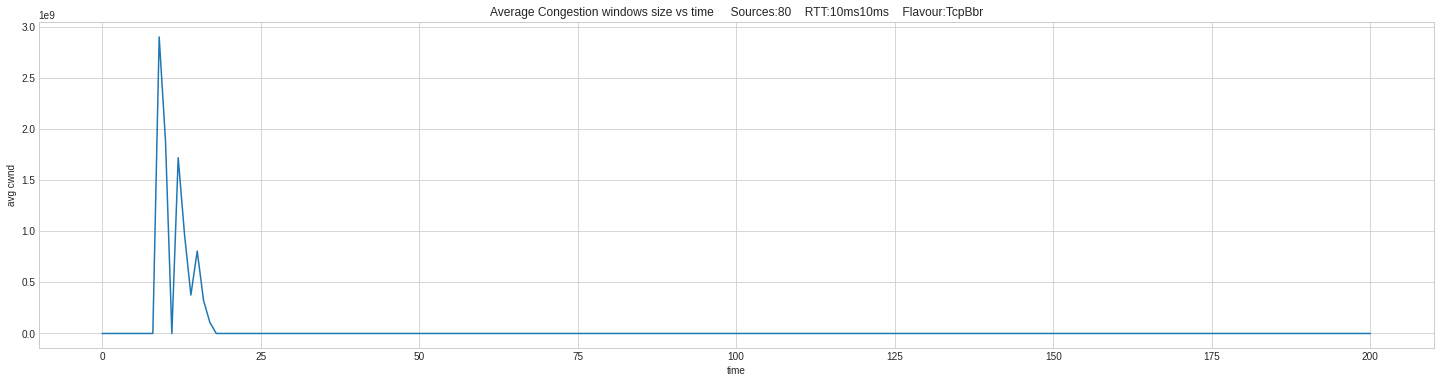

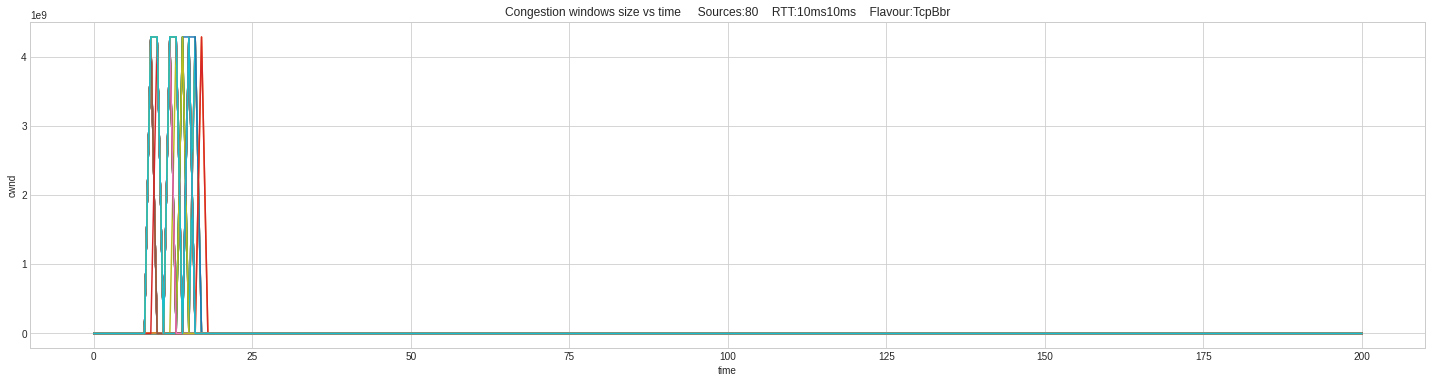

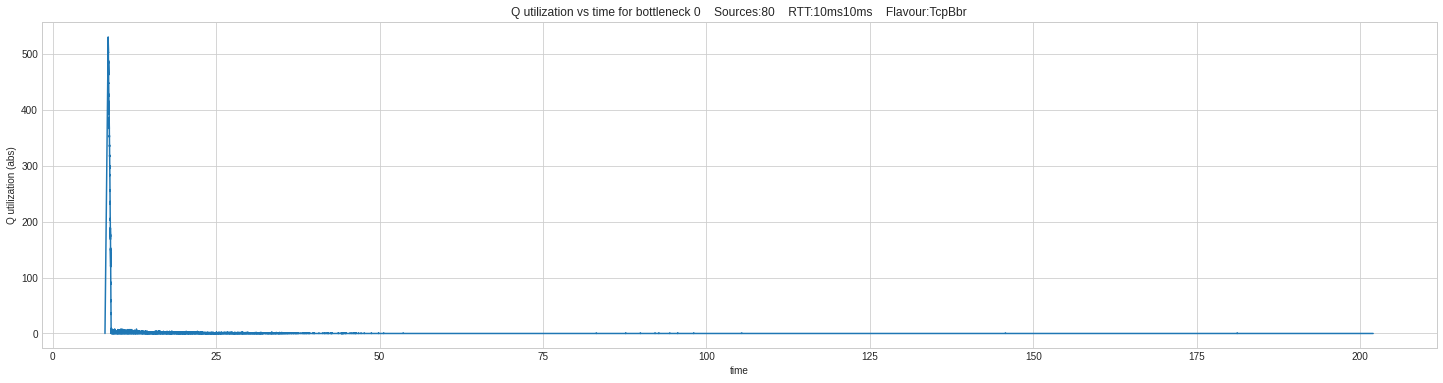

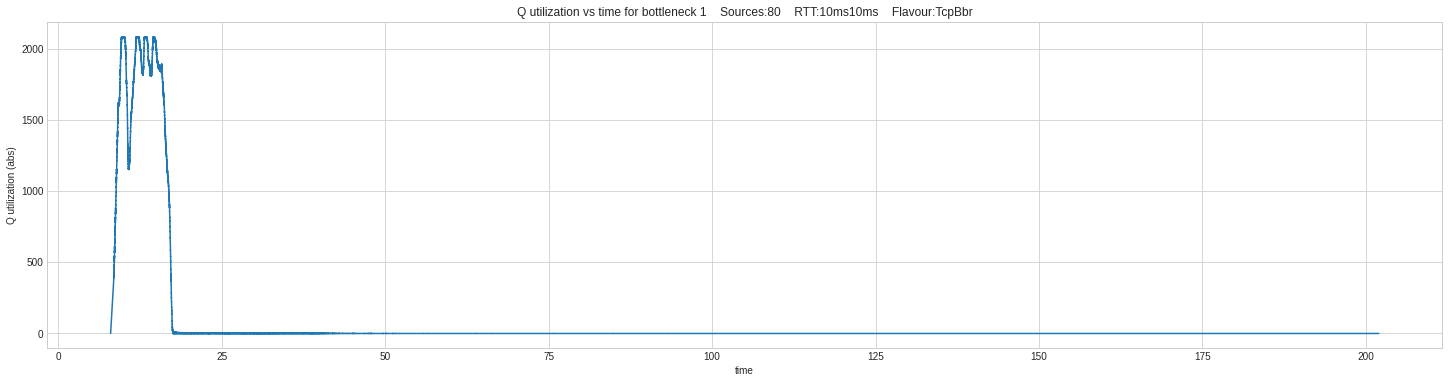

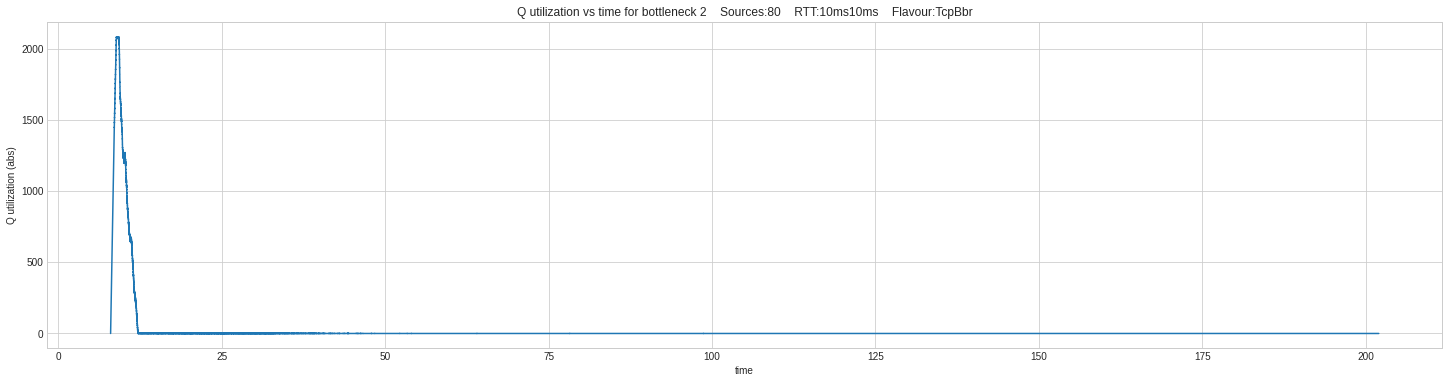

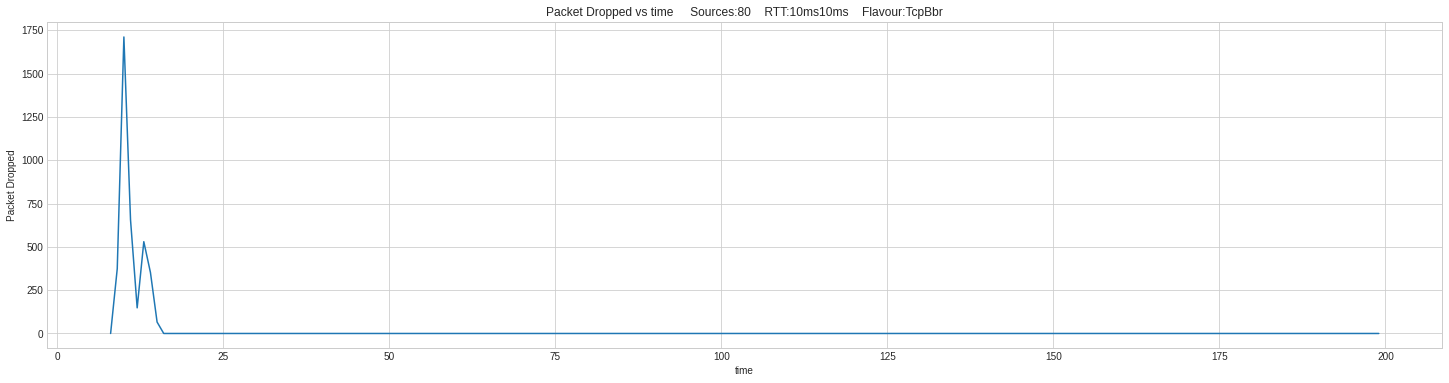

In [166]:
pktSize = 1400
# Sim 1 
main(flavour = "TcpBbr", 
     time = 200, 
     noOfSource = 40*2, 
     total_access_bandwidth = "240Mbps", 
     RTT1 = "10ms",
     RTT2 = "10ms",
     bottleneck_bandwidth_A = "100Mbps",
     bottleneck_bandwidth_B = "100Mbps",
     bottleneck_bandwidth_C = "180Mbps",
     bottleneck_delay = "1ms", 
     packetSize = pktSize, 
     queueL = "2084p", 
     enableBottleneckTrace = 0,
     run_simul = "no",
     part = 0
     )

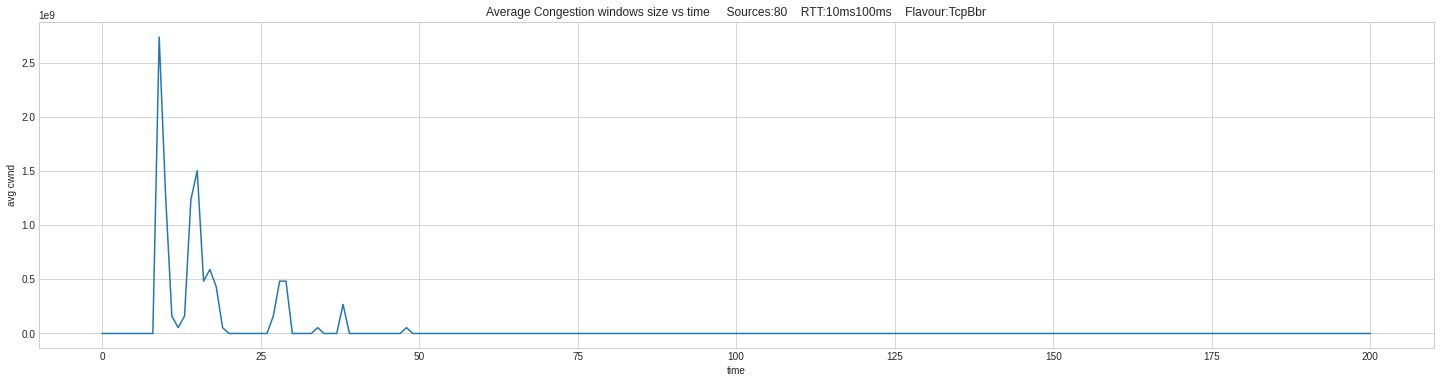

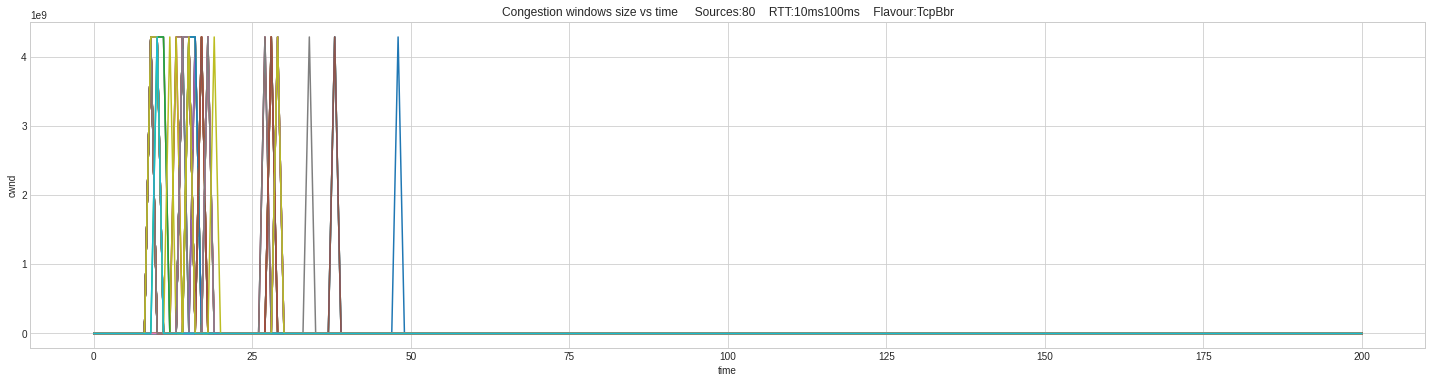

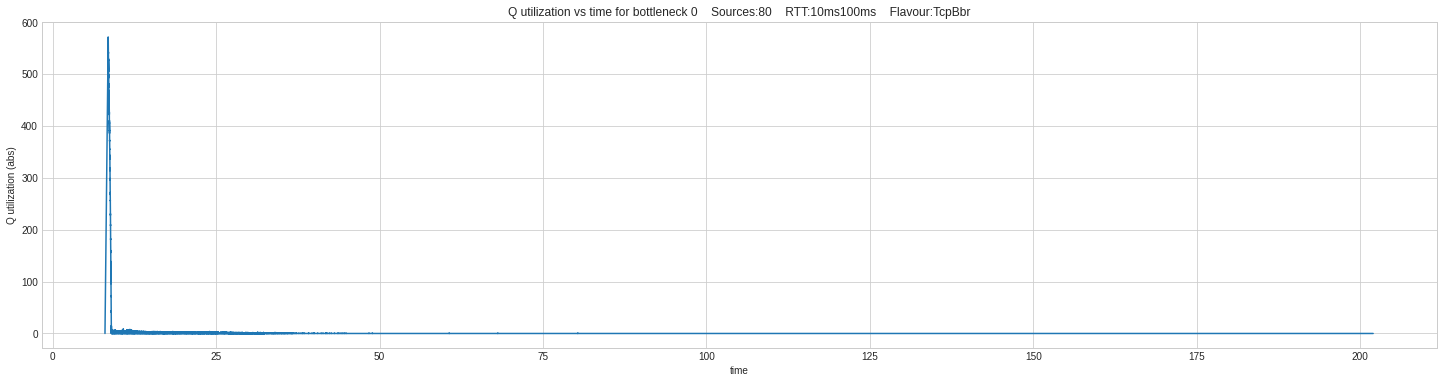

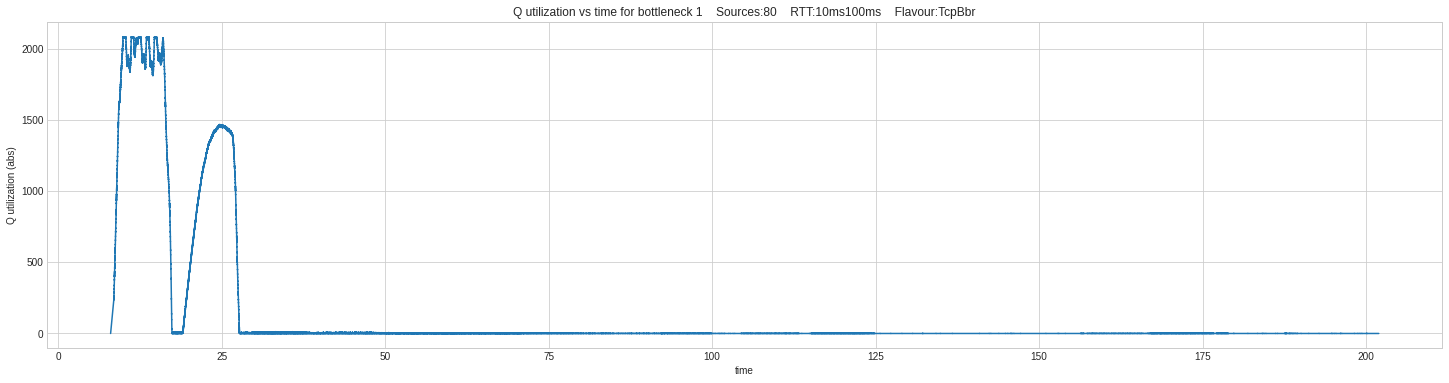

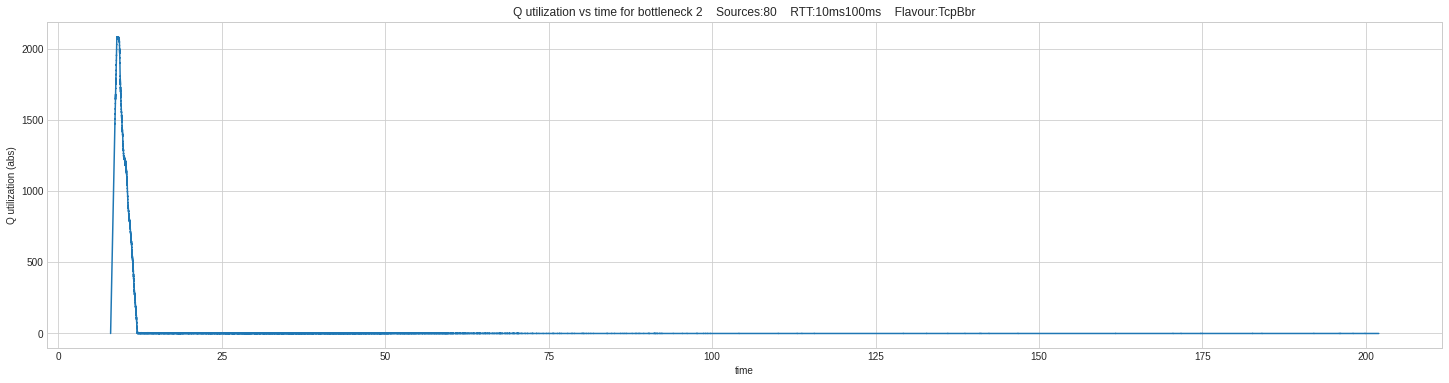

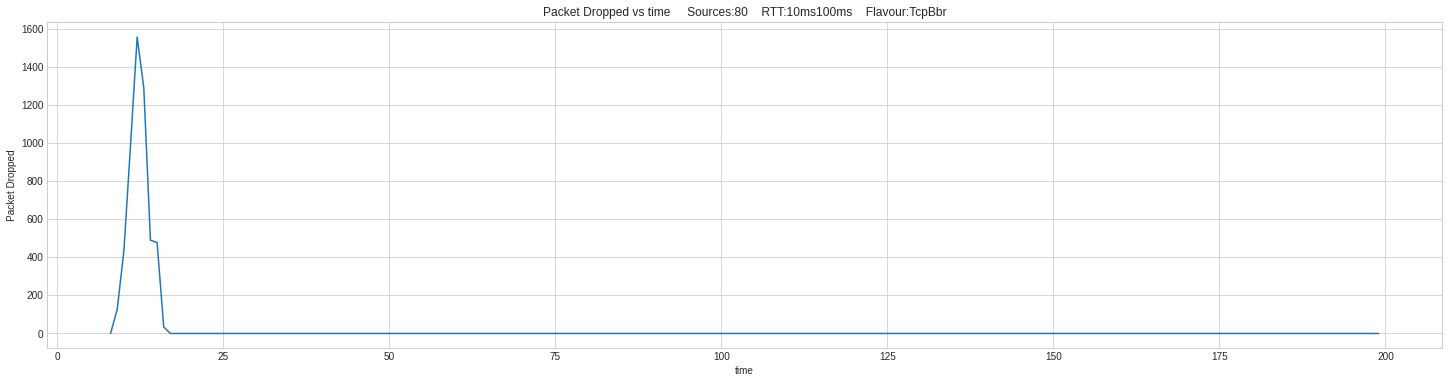

In [167]:
pktSize = 1400
# Sim 2 
main(flavour = "TcpBbr", 
     time = 200, 
     noOfSource = 40*2, 
     total_access_bandwidth = "240Mbps", 
     RTT1 = "10ms",
     RTT2 = "100ms",
     bottleneck_bandwidth_A = "100Mbps",
     bottleneck_bandwidth_B = "100Mbps",
     bottleneck_bandwidth_C = "180Mbps",
     bottleneck_delay = "1ms", 
     packetSize = pktSize, 
     queueL = "2084p", 
     enableBottleneckTrace = 0, run_simul = "no", part = 0 
     )

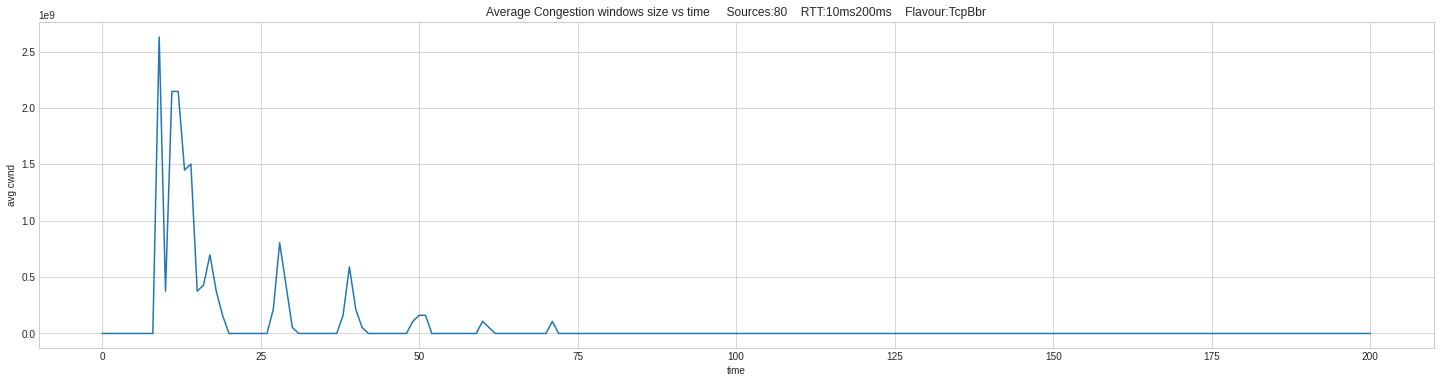

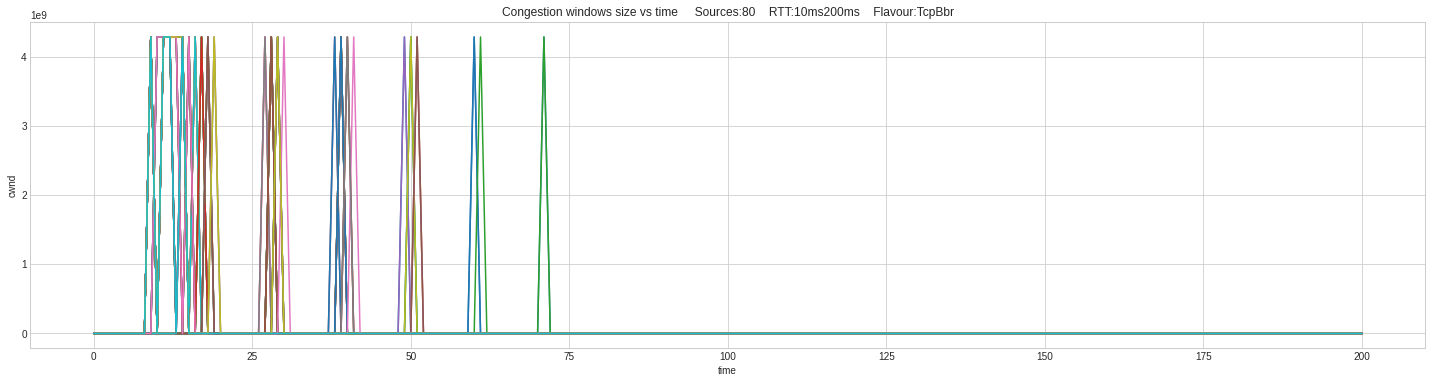

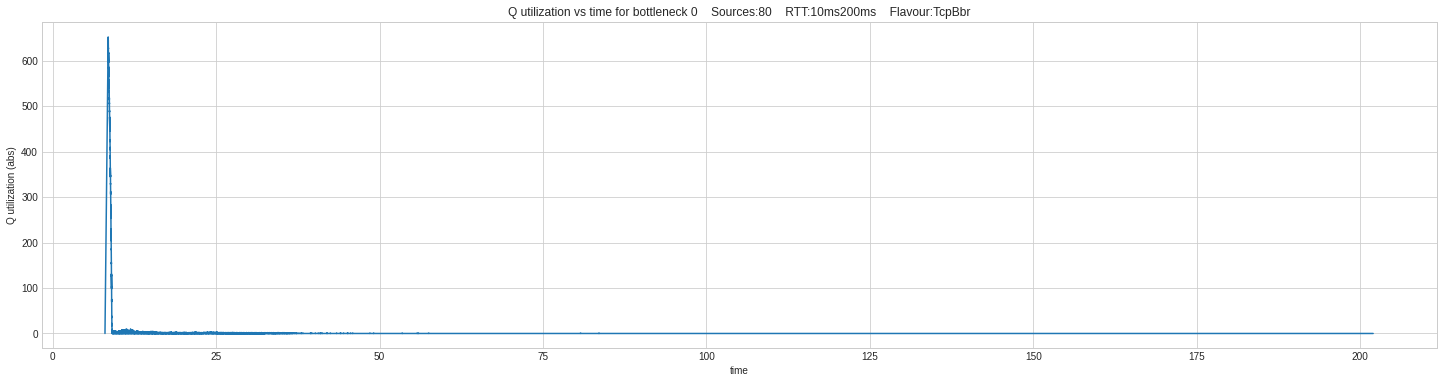

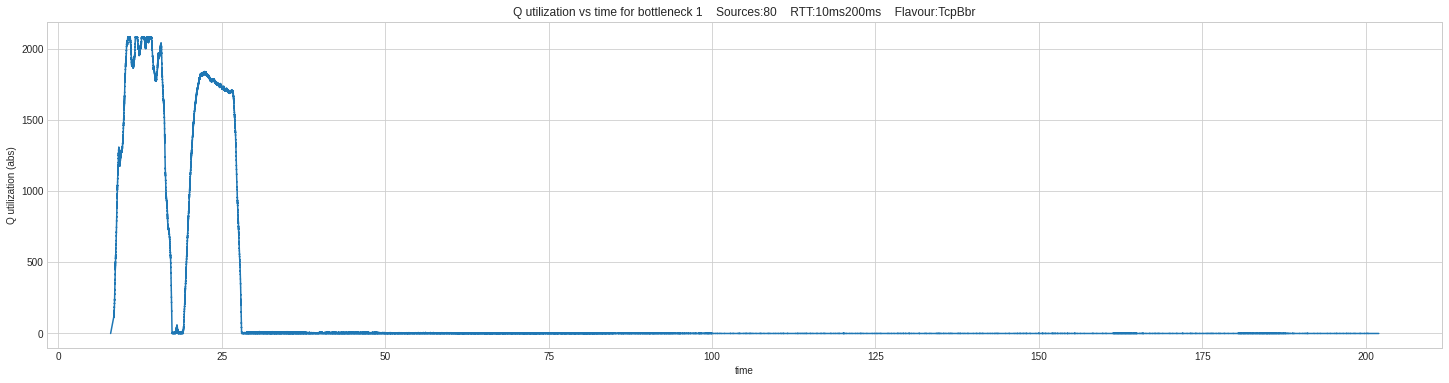

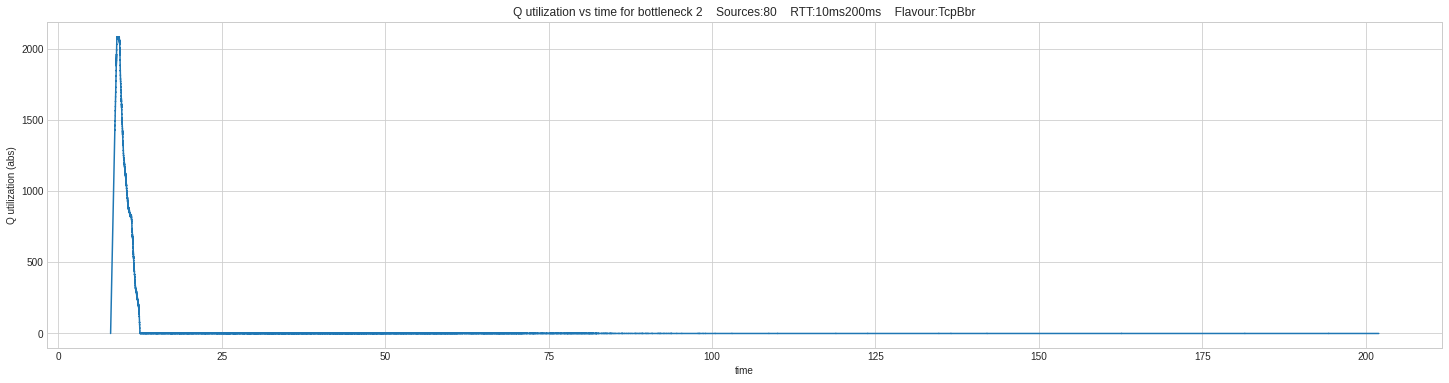

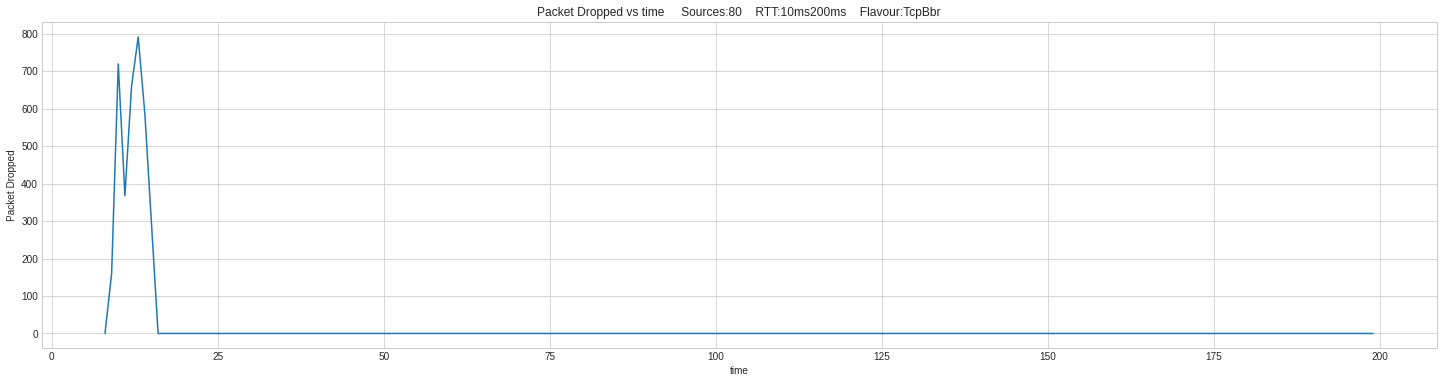

In [168]:
pktSize = 1400
# Sim 3
main(flavour = "TcpBbr", 
     time = 200, 
     noOfSource = 40*2, 
     total_access_bandwidth = "240Mbps", 
     RTT1 = "10ms",
     RTT2 = "200ms",
     bottleneck_bandwidth_A = "100Mbps",
     bottleneck_bandwidth_B = "100Mbps",
     bottleneck_bandwidth_C = "180Mbps",
     bottleneck_delay = "1ms", 
     packetSize = pktSize, 
     queueL = "2084p", 
     enableBottleneckTrace = 0, run_simul = "no", part = 0
     )

[0/2] Re-checking globbed directories...
ninja: no work to do.


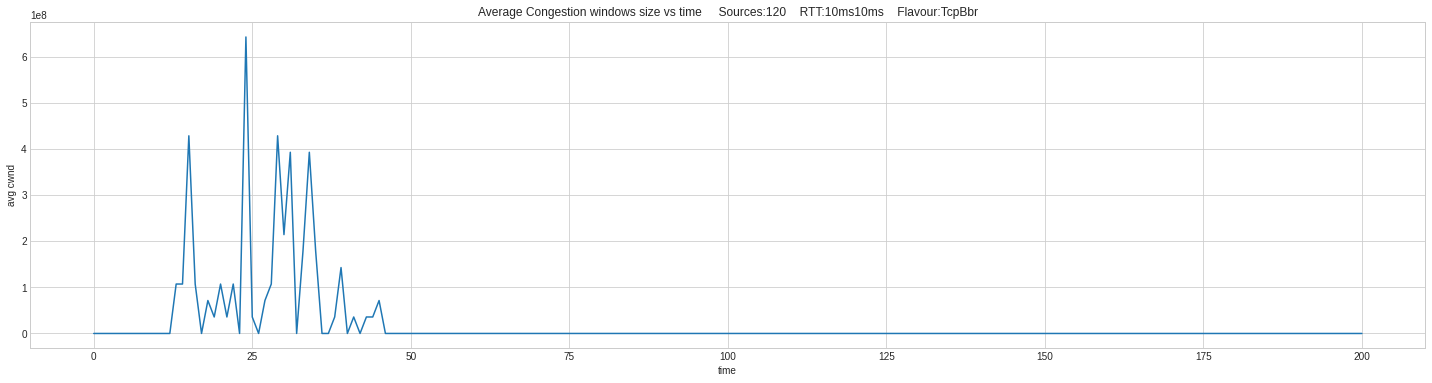

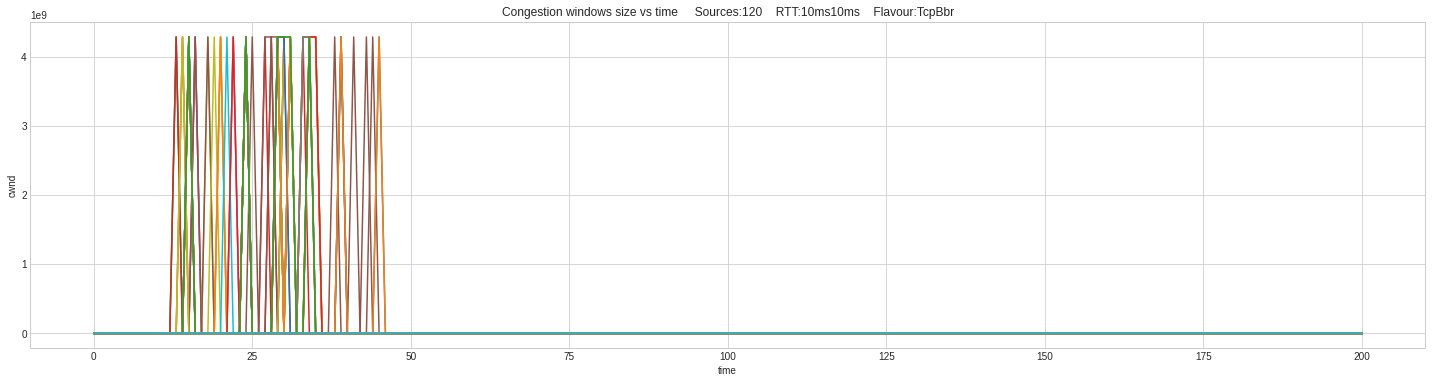

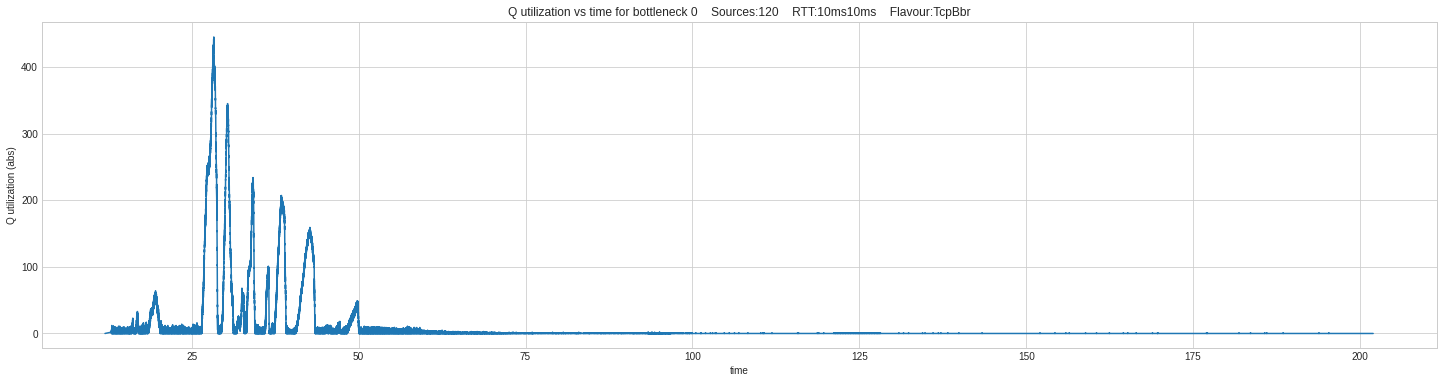

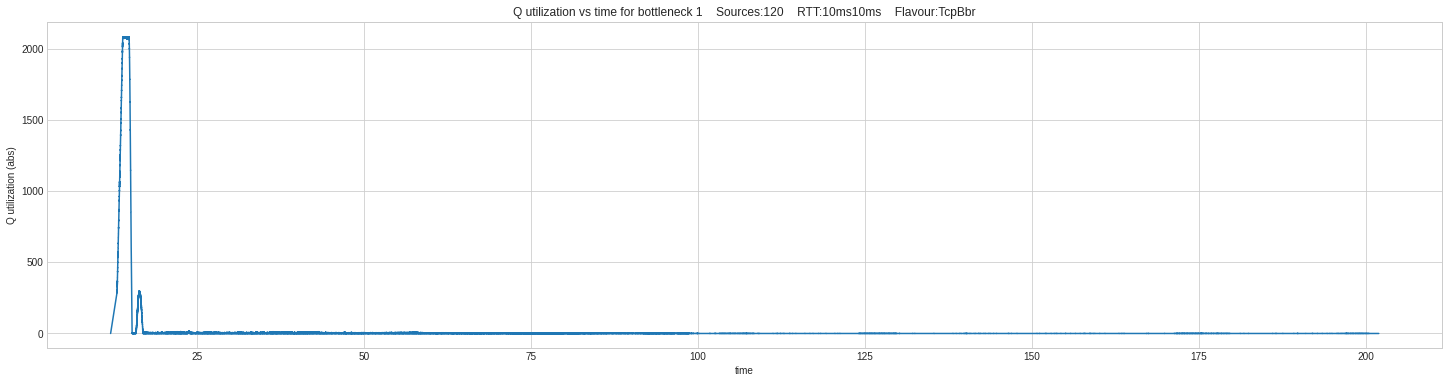

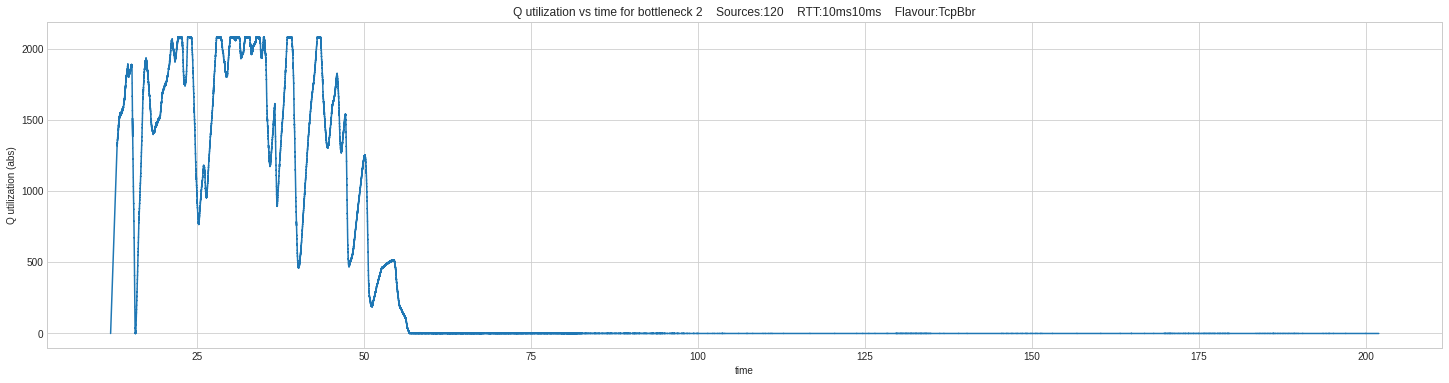

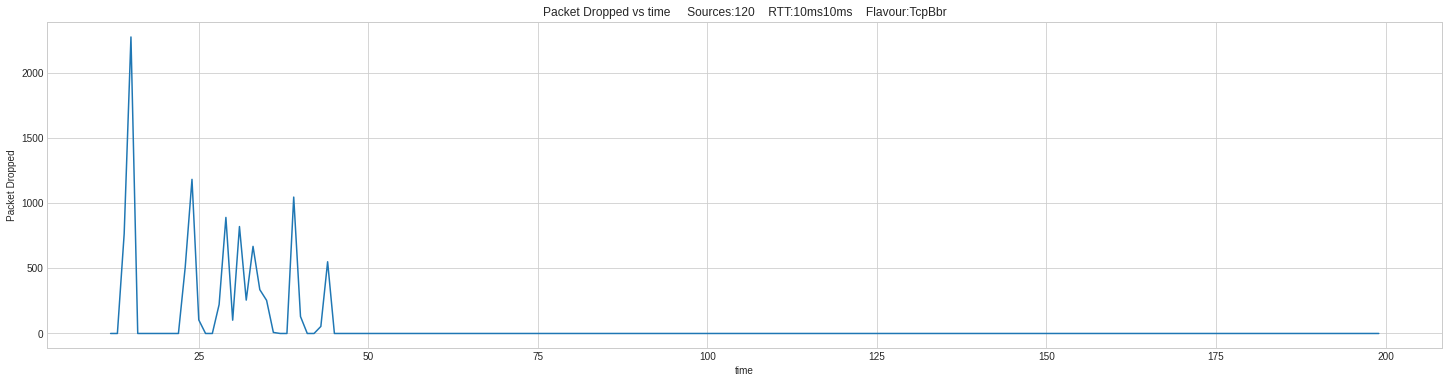

In [169]:
pktSize = 1400
# Sim 4
main(flavour = "TcpBbr", 
     time = 200, 
     noOfSource = 60*2, 
     total_access_bandwidth = "240Mbps", 
     RTT1 = "10ms",
     RTT2 = "10ms",
     bottleneck_bandwidth_A = "100Mbps",
     bottleneck_bandwidth_B = "100Mbps",
     bottleneck_bandwidth_C = "180Mbps",
     bottleneck_delay = "1ms", 
     packetSize = pktSize, 
     queueL = "2084p", 
     enableBottleneckTrace = 0,
     )

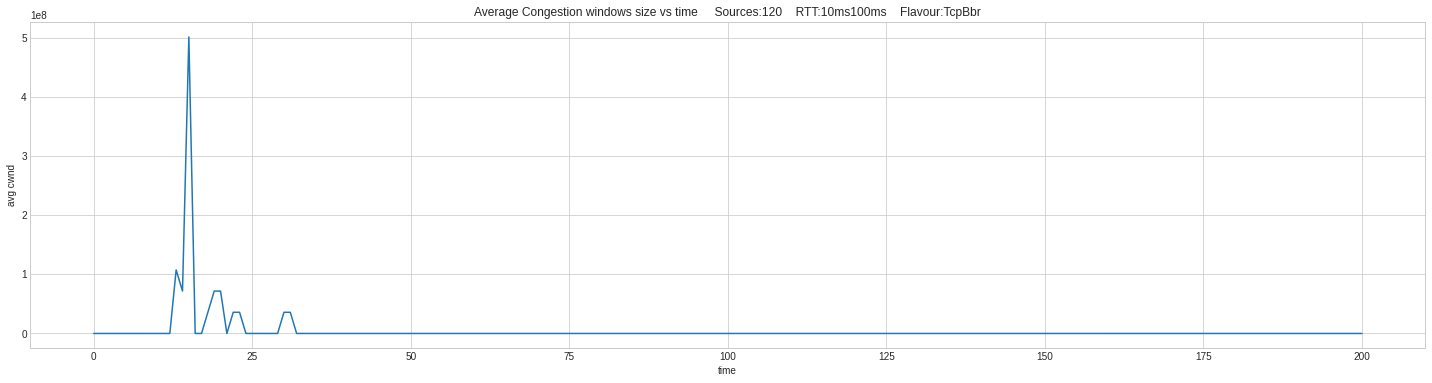

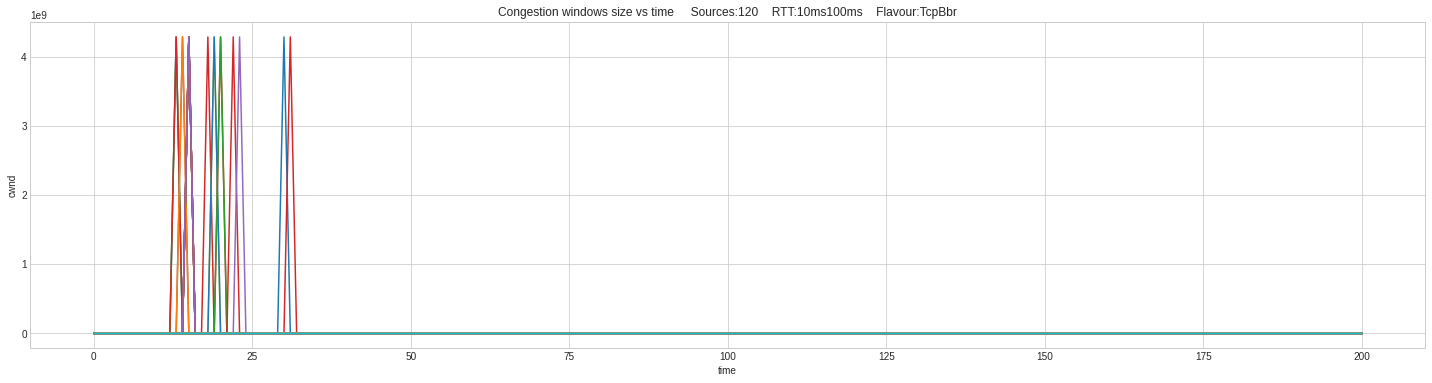

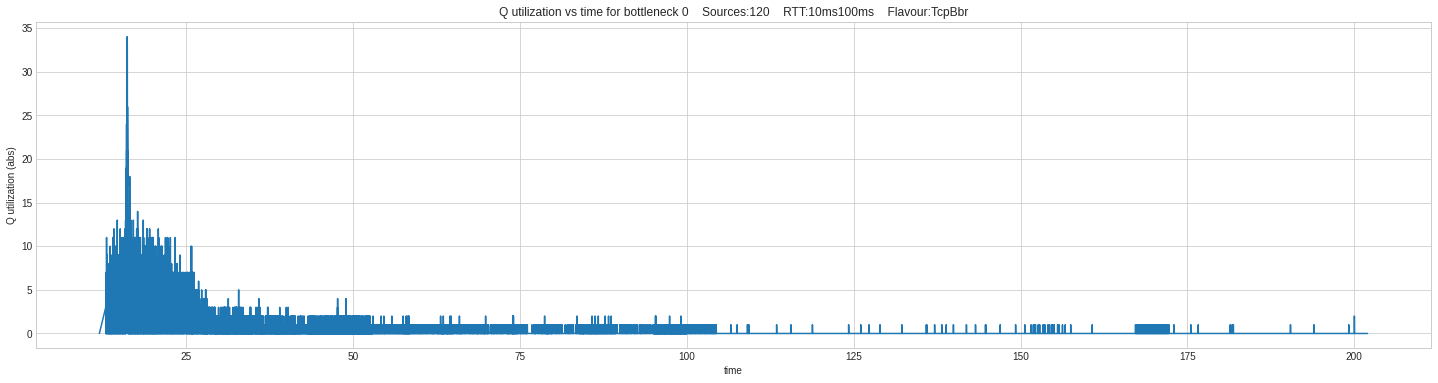

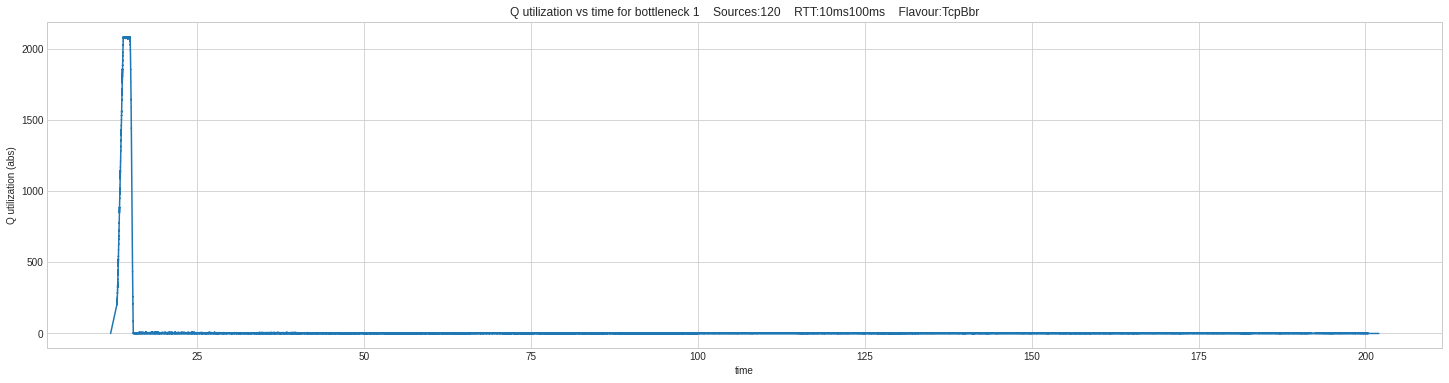

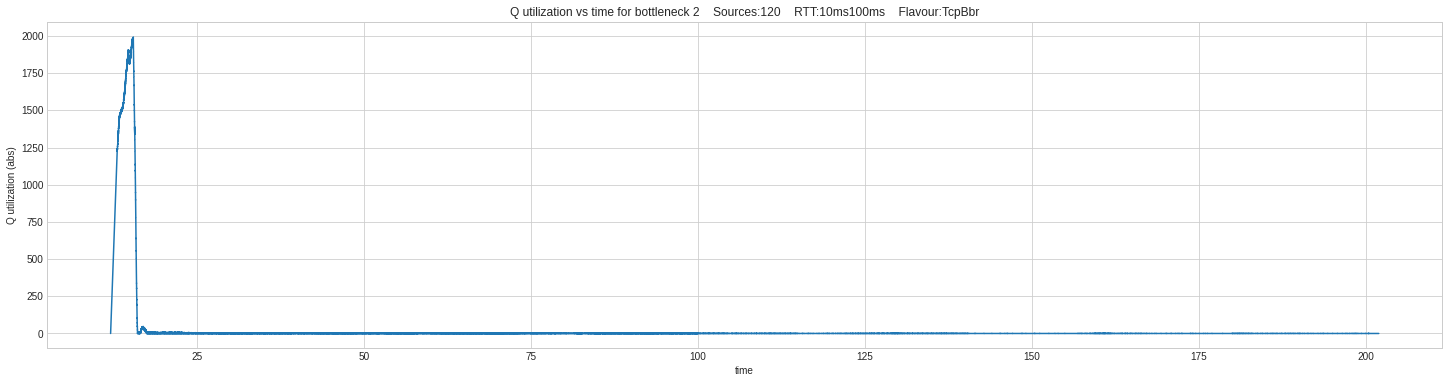

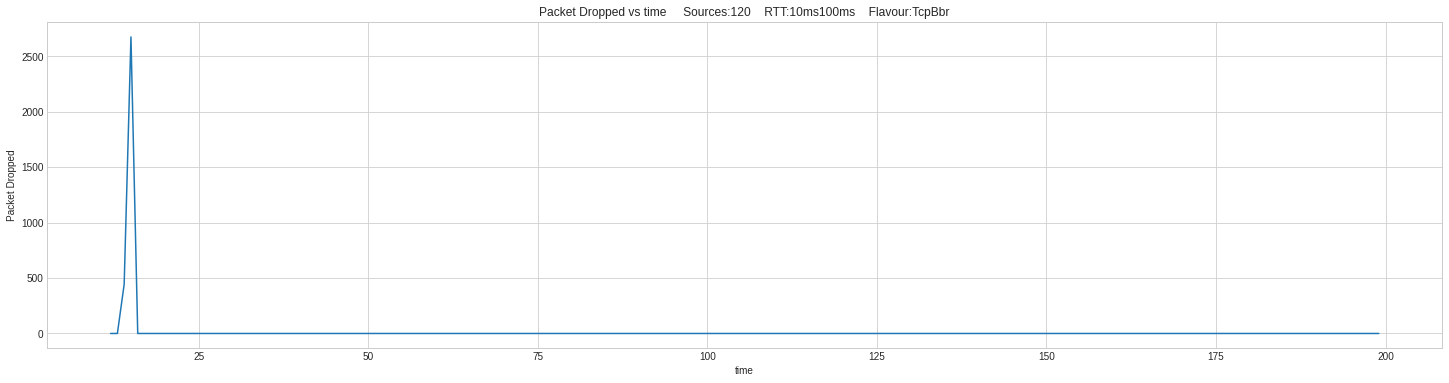

In [170]:
pktSize = 1400
# Sim 5
main(flavour = "TcpBbr", 
     time = 200, 
     noOfSource = 60*2, 
     total_access_bandwidth = "240Mbps", 
     RTT1 = "10ms",
     RTT2 = "100ms",
     bottleneck_bandwidth_A = "100Mbps",
     bottleneck_bandwidth_B = "100Mbps",
     bottleneck_bandwidth_C = "180Mbps",
     bottleneck_delay = "1ms", 
     packetSize = pktSize, 
     queueL = "2084p", 
     enableBottleneckTrace = 0, run_simul = "no", part = 0
     )

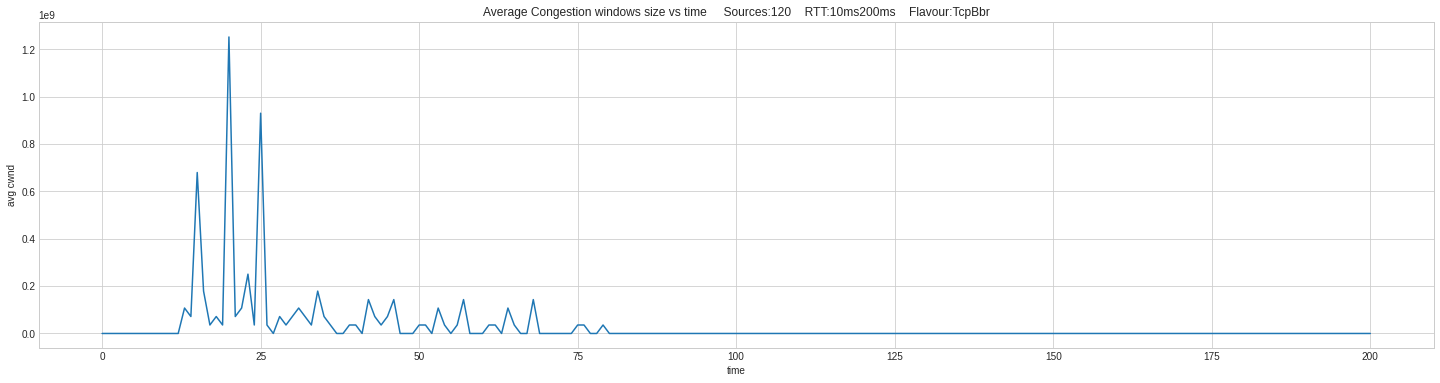

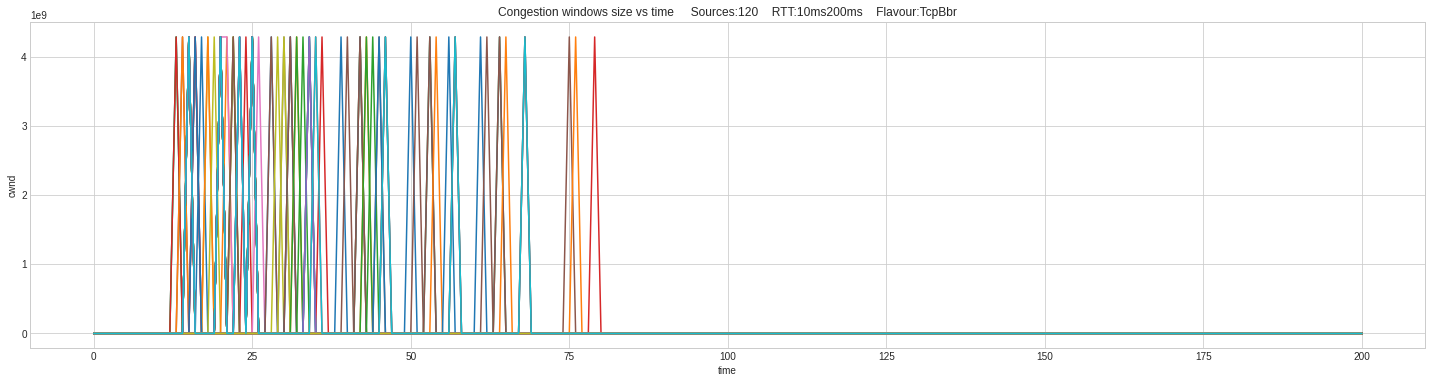

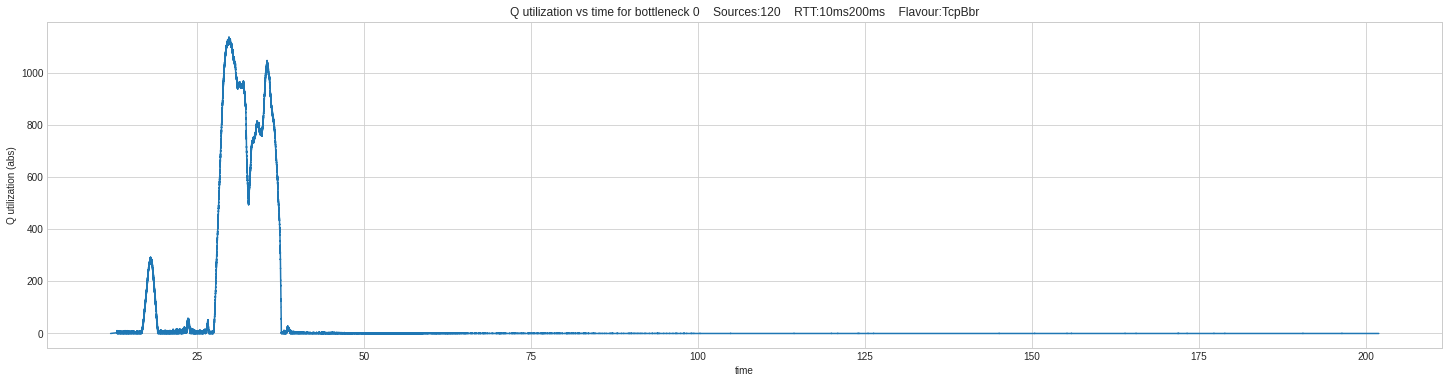

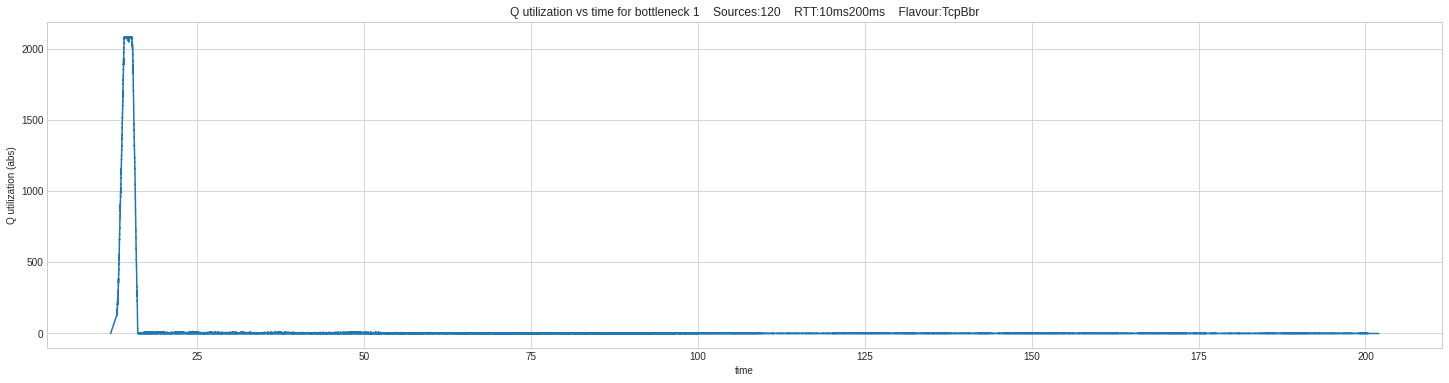

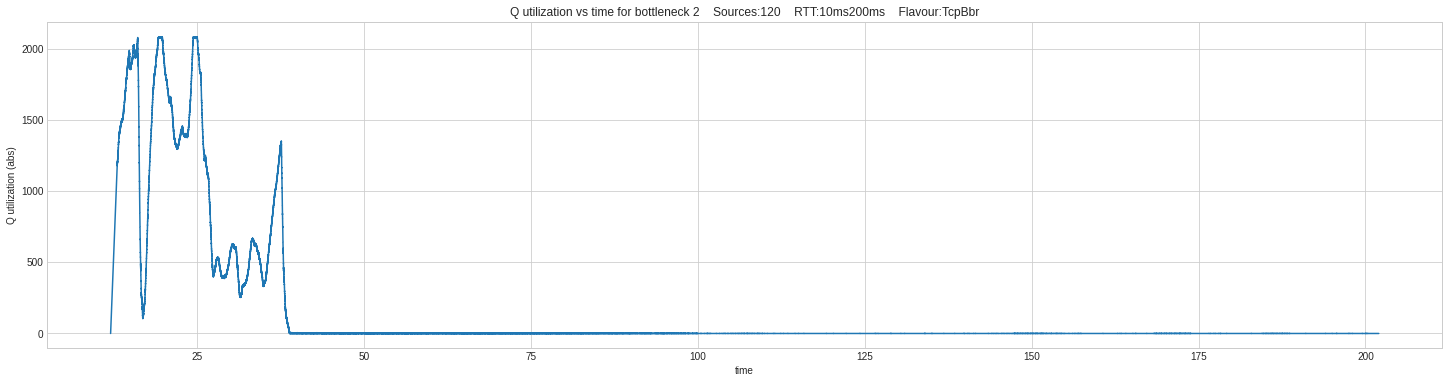

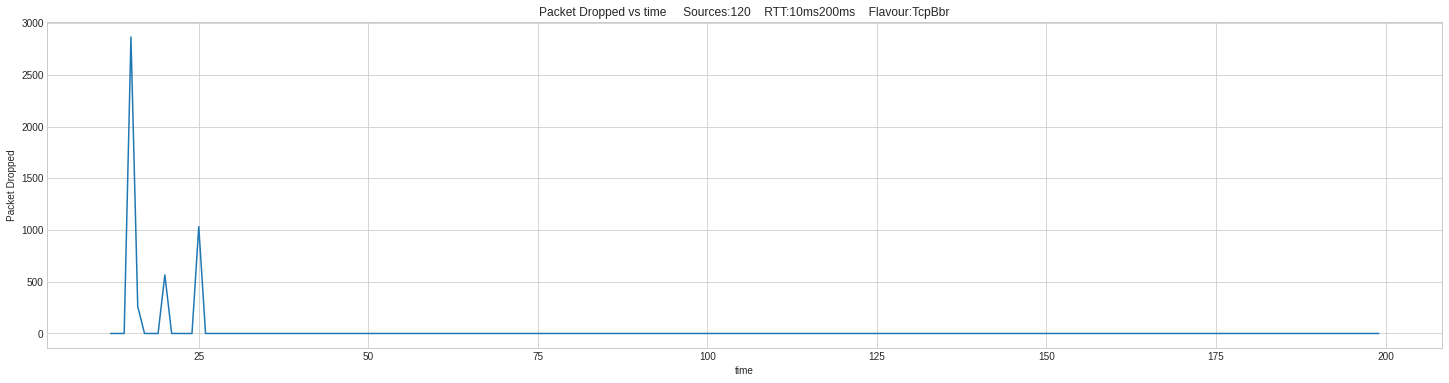

In [171]:
pktSize = 1400
# Sim 6
main(flavour = "TcpBbr", 
     time = 200, 
     noOfSource = 60*2, 
     total_access_bandwidth = "240Mbps", 
     RTT1 = "10ms",
     RTT2 = "200ms",
     bottleneck_bandwidth_A = "100Mbps",
     bottleneck_bandwidth_B = "100Mbps",
     bottleneck_bandwidth_C = "180Mbps",
     bottleneck_delay = "1ms", 
     packetSize = pktSize, 
     queueL = "2084p", 
     enableBottleneckTrace = 0, run_simul = "no", part = 0
     )

In [43]:
pktSize = 1400
# Sim 7
main(flavour = "TcpBbr", 
     time = 200, 
     noOfSource = 80*2, 
     total_access_bandwidth = "240Mbps", 
     RTT1 = "10ms",
     RTT2 = "10ms",
     bottleneck_bandwidth_A = "100Mbps",
     bottleneck_bandwidth_B = "100Mbps",
     bottleneck_bandwidth_C = "180Mbps",
     bottleneck_delay = "1ms", 
     packetSize = pktSize, 
     queueL = "2084p", 
     enableBottleneckTrace = 0,
     )

2084p
[0/2] Re-checking globbed directories...
[1/2] Building CXX object scratch/CMakeFiles/scratch_tcp_ftp_n_bg.dir/tcp_ftp_n_bg.cc.o
[2/2] Linking CXX executable scratch/ns3.36.1-tcp_ftp_n_bg-optimized
Command 'build/scratch/ns3.36.1-tcp_ftp_n_bg-optimized --nSources=160 --flavour=TcpBbr --bottleneckBandwidthA=100Mbps --bottleneckBandwidthB=100Mbps --bottleneckBandwidthC=180Mbps --bottleneckDelay=1ms --accessBandwidth=1.5Mbps --queueSize=2084p --pktSize=1400 --simDuration=200 --enableBottleneckTrace=0 --RTT1=10ms --RTT2=10ms' died with <Signals.SIGABRT: 6>.


msg="Ipv4AddressGeneratorImpl::Add(): Address Collision: 10.6.0.1", +0.000000000s -1 file=/mnt/Store/Project-summer/ns-allinone-3.36.1/ns-3.36.1/src/internet/model/ipv4-address-generator.cc, line=385
terminate called without an active exception


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/Store/Project-summer/runtime/TcpBbr/10ms10ms/160/cwndDropTail.txt'

<Figure size 1800x432 with 0 Axes>

In [ ]:
pktSize = 1400
# Sim 8
main(flavour = "TcpBbr", 
     time = 200, 
     noOfSource = 80*2, 
     total_access_bandwidth = "240Mbps", 
     RTT1 = "10ms",
     RTT2 = "100ms",
     bottleneck_bandwidth_A = "100Mbps",
     bottleneck_bandwidth_B = "100Mbps",
     bottleneck_bandwidth_C = "180Mbps",
     bottleneck_delay = "1ms", 
     packetSize = pktSize, 
     queueL = "2084p", 
     enableBottleneckTrace = 0, run_simul = "no", part = 0
     )

the maths of internet cong control - R shrikanth

In [ ]:
pktSize = 1400
# Sim 9
main(flavour = "TcpBbr", 
     time = 200, 
     noOfSource = 80*2, 
     total_access_bandwidth = "240Mbps", 
     RTT1 = "10ms",
     RTT2 = "200ms",
     bottleneck_bandwidth_A = "100Mbps",
     bottleneck_bandwidth_B = "100Mbps",
     bottleneck_bandwidth_C = "180Mbps",
     bottleneck_delay = "1ms", 
     packetSize = pktSize, 
     queueL = "2084p", 
     enableBottleneckTrace = 0, run_simul = "no", part = 0
     )